<a href="https://colab.research.google.com/github/AhmedZaghl0ul/Machine-Learning/blob/main/Stroke_Classification_(By_CNN).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
!pip install utils
from utils import *
from glob import glob
from itertools import chain
from datetime import datetime
import statistics
from tqdm import tqdm

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16 , DenseNet169 , DenseNet201 , ResNet50 , DenseNet121
from tensorflow.keras.layers import Dense , Conv2D , Flatten , Dropout , MaxPooling2D , GlobalAveragePooling2D
from tensorflow.keras.models import Model , Sequential
from tensorflow.keras.metrics import Accuracy , Recall , AUC , BinaryAccuracy , FalsePositives , FalseNegatives
from tensorflow.keras.callbacks import CSVLogger , ModelCheckpoint , ReduceLROnPlateau , EarlyStopping
from tensorflow.keras.optimizers import Adam , SGD
from tensorflow.keras.losses import BinaryCrossentropy
from keras import backend as K

In [4]:
path , dirs , files = next(os.walk("/content/drive/MyDrive/DataSets/Brain_Data_Organised/Train/Stroke"))
file_count = len(files)
print('Stroke : ' , file_count)
path , dirs , files = next(os.walk("/content/drive/MyDrive/DataSets/Brain_Data_Organised/Train/Normal"))
file_count = len(files)
print('NO Stroke : ' , file_count)


Stroke :  950
NO Stroke :  1426


In [5]:
image_size = (224 , 224)
batch_Size = 32

train_df = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/DataSets/Brain_Data_Organised/Train",
    shuffle = True,
    validation_split = 0.2,
    subset = "training",
    seed=1337,
    image_size = image_size,
    batch_size = batch_Size
)

val_df = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/DataSets/Brain_Data_Organised/Train",
    shuffle = True,
    validation_split = 0.2,
    subset = "validation",
    seed=333,
    image_size = image_size,
    batch_size = batch_Size
)

test_df = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/DataSets/Brain_Data_Organised/Test",
    shuffle = False,
    image_size = image_size,
    batch_size = batch_Size
)

Found 2376 files belonging to 2 classes.
Using 1901 files for training.
Found 2376 files belonging to 2 classes.
Using 475 files for validation.
Found 250 files belonging to 2 classes.


In [6]:
ytrue = np.concatenate([y for x, y in test_df], axis=0)

In [7]:
train_df = train_df.prefetch(buffer_size=32)
val_df = val_df.prefetch(buffer_size=32)

In [8]:
img_ind = 224
img_shape = (img_ind , img_ind , 3)
Loss = BinaryCrossentropy()
imgSize  =(224,224)
seed = 2
Batchsize = 16

In [9]:
def get_callbaks(model_name):
  callbacks = []

  checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath = f"model.{model_name}.h5" , verbose=1 , save_best_only=True , monitor="val_loss" , mode = "min" , )
  callbacks.append(checkpoint)
  anne = ReduceLROnPlateau(monitor="val_loss" , patience=5 , fator=0.5 , min_lr = 0.0000000001 , min_delta=0.00001 , verbose=1)
  callbacks.append(anne)
  early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='min')
  callbacks.append(early_stopping)

  return callbacks

In [10]:
optimizer = Adam(learning_rate=0.001 , decay=1e-6 , beta_1=0.9 , beta_2=0.999 , epsilon=1e-07)
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=img_shape)
x = base_model.output

x = GlobalAveragePooling2D()(x)
predictions = Dense(1, activation='sigmoid' , name='Final')(x)

model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer=optimizer, loss=Loss, metrics=['accuracy' , keras.metrics.Precision() , keras.metrics.Recall()])

/usr/local/lib/python3.12/dist-packages/keras/src/optimizers/base_optimizer.py:86: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


In [11]:
print(len(model.layers))

429


In [12]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d      │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,408 │ zero_padding2d[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_1    │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 56, 56,    │          0 │ zero_padding2d_1… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │        256 │ pool1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_relu │ (None, 56, 56,    │          0 │ conv2_block1_0_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      8,192 │ conv2_block1_0_r… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        512 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,864 │ conv2_block1_1_r… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_concat │ (None, 56, 56,    │          0 │ pool1[0][0],      │
│ (Concatenate)       │ 96)               │            │ conv2_block1_2_c… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_bn   │ (None, 56, 56,    │        384 │ conv2_block1_con… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_relu │ (None, 56, 56,    │          0 │ conv2_block2_0_b… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_1_conv │ (None, 56, 56,    │     12,288 │ conv2_block2_0_r

 Total params: 7,038,529 (26.85 MB)

 Trainable params: 6,954,881 (26.53 MB)

 Non-trainable params: 83,648 (326.75 KB)

In [13]:
callbacks = get_callbaks("DenseNet121")
history = model.fit(
    train_df,
    epochs=50,
    validation_data=val_df,
    callbacks=[callbacks]
)

Epoch 1/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6529 - loss: 0.7157 - precision: 0.5721 - recall: 0.5187   
Epoch 1: val_loss improved from inf to 3.68351, saving model to model.DenseNet121.h5


60/60 ━━━━━━━━━━━━━━━━━━━━ 355s 3s/step - accuracy: 0.6540 - loss: 0.7136 - precision: 0.5736 - recall: 0.5202 - val_accuracy: 0.5789 - val_loss: 3.6835 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0010
Epoch 2/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step - accuracy: 0.8401 - loss: 0.3635 - precision: 0.7966 - recall: 0.8073
Epoch 2: val_loss did not improve from 3.68351
60/60 ━━━━━━━━━━━━━━━━━━━━ 19s 314ms/step - accuracy: 0.8402 - loss: 0.3633 - precision: 0.7968 - recall: 0.8072 - val_accuracy: 0.4821 - val_loss: 10.3976 - val_precision: 0.4484 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 3/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step - accuracy: 0.9046 - loss: 0.2479 - precision: 0.8984 - recall: 0.8628
Epoch 3: val_loss improved from 3.68351 to 0.37059, saving model to model.DenseNet121.h5


60/60 ━━━━━━━━━━━━━━━━━━━━ 19s 324ms/step - accuracy: 0.9048 - loss: 0.2472 - precision: 0.8985 - recall: 0.8632 - val_accuracy: 0.8947 - val_loss: 0.3706 - val_precision: 0.9213 - val_recall: 0.8200 - learning_rate: 0.0010
Epoch 4/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step - accuracy: 0.9301 - loss: 0.1693 - precision: 0.9279 - recall: 0.8969
Epoch 4: val_loss did not improve from 0.37059
60/60 ━━━━━━━━━━━━━━━━━━━━ 20s 323ms/step - accuracy: 0.9302 - loss: 0.1691 - precision: 0.9279 - recall: 0.8971 - val_accuracy: 0.9095 - val_loss: 0.4010 - val_precision: 0.9876 - val_recall: 0.7950 - learning_rate: 0.0010
Epoch 5/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step - accuracy: 0.9590 - loss: 0.0956 - precision: 0.9420 - recall: 0.9568
Epoch 5: val_loss did not improve from 0.37059
60/60 ━━━━━━━━━━━━━━━━━━━━ 18s 303ms/step - accuracy: 0.9590 - loss: 0.0956 - precision: 0.9421 - recall: 0.9568 - val_accuracy: 0.7453 - val_loss: 1.1343 - val_precision: 1.0000 - val_recall: 0.3950 - learning_r

60/60 ━━━━━━━━━━━━━━━━━━━━ 21s 340ms/step - accuracy: 0.9863 - loss: 0.0459 - precision: 0.9862 - recall: 0.9796 - val_accuracy: 0.9747 - val_loss: 0.0653 - val_precision: 0.9845 - val_recall: 0.9550 - learning_rate: 0.0010
Epoch 8/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step - accuracy: 0.9268 - loss: 0.1951 - precision: 0.9289 - recall: 0.8858
Epoch 8: val_loss did not improve from 0.06527
60/60 ━━━━━━━━━━━━━━━━━━━━ 19s 318ms/step - accuracy: 0.9268 - loss: 0.1949 - precision: 0.9287 - recall: 0.8860 - val_accuracy: 0.8779 - val_loss: 0.6270 - val_precision: 0.7752 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 9/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 277ms/step - accuracy: 0.9724 - loss: 0.0876 - precision: 0.9762 - recall: 0.9545
Epoch 9: val_loss did not improve from 0.06527
60/60 ━━━━━━━━━━━━━━━━━━━━ 19s 321ms/step - accuracy: 0.9724 - loss: 0.0876 - precision: 0.9761 - recall: 0.9546 - val_accuracy: 0.9726 - val_loss: 0.0774 - val_precision: 0.9845 - val_recall: 0.9500 - learning_r

60/60 ━━━━━━━━━━━━━━━━━━━━ 20s 335ms/step - accuracy: 0.9896 - loss: 0.0412 - precision: 0.9936 - recall: 0.9811 - val_accuracy: 0.9979 - val_loss: 0.0241 - val_precision: 0.9950 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 11/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step - accuracy: 0.9953 - loss: 0.0176 - precision: 0.9960 - recall: 0.9922
Epoch 11: val_loss did not improve from 0.02408
60/60 ━━━━━━━━━━━━━━━━━━━━ 20s 326ms/step - accuracy: 0.9953 - loss: 0.0177 - precision: 0.9960 - recall: 0.9922 - val_accuracy: 0.9495 - val_loss: 0.1022 - val_precision: 0.8929 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 12/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step - accuracy: 0.9987 - loss: 0.0109 - precision: 0.9985 - recall: 0.9982
Epoch 12: val_loss improved from 0.02408 to 0.01024, saving model to model.DenseNet121.h5


60/60 ━━━━━━━━━━━━━━━━━━━━ 20s 328ms/step - accuracy: 0.9987 - loss: 0.0109 - precision: 0.9985 - recall: 0.9982 - val_accuracy: 0.9979 - val_loss: 0.0102 - val_precision: 1.0000 - val_recall: 0.9950 - learning_rate: 0.0010
Epoch 13/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step - accuracy: 1.0000 - loss: 0.0027 - precision: 1.0000 - recall: 1.0000
Epoch 13: val_loss improved from 0.01024 to 0.00384, saving model to model.DenseNet121.h5


60/60 ━━━━━━━━━━━━━━━━━━━━ 21s 348ms/step - accuracy: 1.0000 - loss: 0.0027 - precision: 1.0000 - recall: 1.0000 - val_accuracy: 0.9979 - val_loss: 0.0038 - val_precision: 1.0000 - val_recall: 0.9950 - learning_rate: 0.0010
Epoch 14/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step - accuracy: 0.9974 - loss: 0.0077 - precision: 0.9991 - recall: 0.9943
Epoch 14: val_loss did not improve from 0.00384
60/60 ━━━━━━━━━━━━━━━━━━━━ 19s 313ms/step - accuracy: 0.9974 - loss: 0.0078 - precision: 0.9991 - recall: 0.9943 - val_accuracy: 0.9979 - val_loss: 0.0210 - val_precision: 0.9950 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 15/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step - accuracy: 0.9547 - loss: 0.1361 - precision: 0.9442 - recall: 0.9427
Epoch 15: val_loss did not improve from 0.00384
60/60 ━━━━━━━━━━━━━━━━━━━━ 19s 313ms/step - accuracy: 0.9546 - loss: 0.1361 - precision: 0.9442 - recall: 0.9425 - val_accuracy: 0.9095 - val_loss: 0.3691 - val_precision: 0.9153 - val_recall: 0.8650 - learni

60/60 ━━━━━━━━━━━━━━━━━━━━ 19s 323ms/step - accuracy: 1.0000 - loss: 0.0023 - precision: 1.0000 - recall: 1.0000 - val_accuracy: 0.9979 - val_loss: 0.0034 - val_precision: 0.9950 - val_recall: 1.0000 - learning_rate: 1.0000e-04
Epoch 24/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step - accuracy: 1.0000 - loss: 0.0023 - precision: 1.0000 - recall: 1.0000
Epoch 24: val_loss did not improve from 0.00340
60/60 ━━━━━━━━━━━━━━━━━━━━ 19s 312ms/step - accuracy: 1.0000 - loss: 0.0023 - precision: 1.0000 - recall: 1.0000 - val_accuracy: 0.9979 - val_loss: 0.0035 - val_precision: 0.9950 - val_recall: 1.0000 - learning_rate: 1.0000e-04
Epoch 25/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step - accuracy: 1.0000 - loss: 0.0026 - precision: 1.0000 - recall: 1.0000
Epoch 25: val_loss improved from 0.00340 to 0.00323, saving model to model.DenseNet121.h5


60/60 ━━━━━━━━━━━━━━━━━━━━ 19s 322ms/step - accuracy: 1.0000 - loss: 0.0026 - precision: 1.0000 - recall: 1.0000 - val_accuracy: 0.9979 - val_loss: 0.0032 - val_precision: 0.9950 - val_recall: 1.0000 - learning_rate: 1.0000e-04
Epoch 26/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step - accuracy: 1.0000 - loss: 0.0015 - precision: 1.0000 - recall: 1.0000
Epoch 26: val_loss improved from 0.00323 to 0.00279, saving model to model.DenseNet121.h5


60/60 ━━━━━━━━━━━━━━━━━━━━ 21s 345ms/step - accuracy: 1.0000 - loss: 0.0015 - precision: 1.0000 - recall: 1.0000 - val_accuracy: 0.9979 - val_loss: 0.0028 - val_precision: 0.9950 - val_recall: 1.0000 - learning_rate: 1.0000e-04
Epoch 27/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step - accuracy: 1.0000 - loss: 0.0012 - precision: 1.0000 - recall: 1.0000
Epoch 27: val_loss did not improve from 0.00279
60/60 ━━━━━━━━━━━━━━━━━━━━ 18s 300ms/step - accuracy: 1.0000 - loss: 0.0012 - precision: 1.0000 - recall: 1.0000 - val_accuracy: 0.9979 - val_loss: 0.0028 - val_precision: 0.9950 - val_recall: 1.0000 - learning_rate: 1.0000e-04
Epoch 28/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step - accuracy: 1.0000 - loss: 0.0011 - precision: 1.0000 - recall: 1.0000
Epoch 28: val_loss improved from 0.00279 to 0.00270, saving model to model.DenseNet121.h5


60/60 ━━━━━━━━━━━━━━━━━━━━ 21s 348ms/step - accuracy: 1.0000 - loss: 0.0011 - precision: 1.0000 - recall: 1.0000 - val_accuracy: 0.9979 - val_loss: 0.0027 - val_precision: 0.9950 - val_recall: 1.0000 - learning_rate: 1.0000e-04
Epoch 29/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step - accuracy: 1.0000 - loss: 0.0014 - precision: 0.9999 - recall: 1.0000
Epoch 29: val_loss improved from 0.00270 to 0.00227, saving model to model.DenseNet121.h5


60/60 ━━━━━━━━━━━━━━━━━━━━ 20s 339ms/step - accuracy: 1.0000 - loss: 0.0014 - precision: 0.9999 - recall: 1.0000 - val_accuracy: 1.0000 - val_loss: 0.0023 - val_precision: 1.0000 - val_recall: 1.0000 - learning_rate: 1.0000e-04
Epoch 30/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step - accuracy: 1.0000 - loss: 0.0026 - precision: 1.0000 - recall: 1.0000
Epoch 30: val_loss did not improve from 0.00227
60/60 ━━━━━━━━━━━━━━━━━━━━ 19s 320ms/step - accuracy: 1.0000 - loss: 0.0026 - precision: 1.0000 - recall: 1.0000 - val_accuracy: 0.9979 - val_loss: 0.0030 - val_precision: 0.9950 - val_recall: 1.0000 - learning_rate: 1.0000e-04
Epoch 31/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step - accuracy: 1.0000 - loss: 9.9259e-04 - precision: 1.0000 - recall: 1.0000
Epoch 31: val_loss did not improve from 0.00227
60/60 ━━━━━━━━━━━━━━━━━━━━ 19s 312ms/step - accuracy: 1.0000 - loss: 9.9344e-04 - precision: 1.0000 - recall: 1.0000 - val_accuracy: 0.9979 - val_loss: 0.0028 - val_precision: 0.9950 - val_recall:

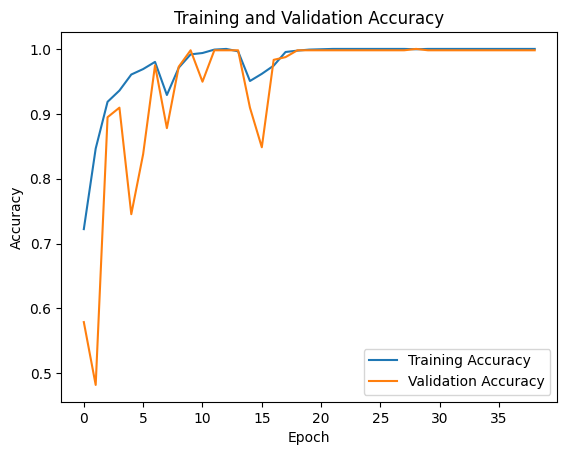

In [14]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

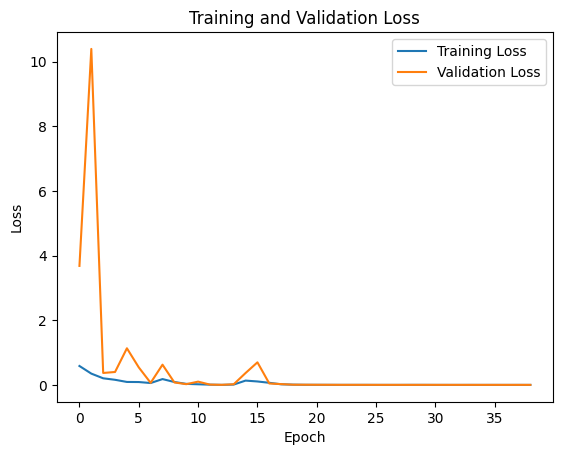

In [15]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [16]:
model = keras.models.load_model("model.DenseNet121.h5")

In [17]:
results = model.evaluate(test_df , verbose=1)

8/8 ━━━━━━━━━━━━━━━━━━━━ 29s 2s/step - accuracy: 0.9705 - loss: 0.0739 - precision: 0.5505 - recall: 0.6638


In [18]:
ypred  = model.predict(test_df).round()
ypred = ypred.flatten()

8/8 ━━━━━━━━━━━━━━━━━━━━ 24s 2s/step


In [19]:
from sklearn.metrics import classification_report

print(classification_report(ytrue, ypred))

              precision    recall  f1-score   support

           0       0.99      0.95      0.97       125
           1       0.95      0.99      0.97       125

    accuracy                           0.97       250
   macro avg       0.97      0.97      0.97       250
weighted avg       0.97      0.97      0.97       250



In [20]:
from tensorflow.keras.applications import ResNet50

optimizer = Adam(learning_rate=0.001 , decay=1e-6 , beta_1=0.9 , beta_2=0.999 , epsilon=1e-07)
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=img_shape)
x = base_model.output

x = GlobalAveragePooling2D()(x)
predictions = Dense(1, activation='sigmoid' , name='Final')(x)

model = Model(inputs=base_model.input, outputs=predictions)

/usr/local/lib/python3.12/dist-packages/keras/src/optimizers/base_optimizer.py:86: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


In [21]:
model.compile(optimizer=optimizer, loss=Loss, metrics=['accuracy' , keras.metrics.Precision() , keras.metrics.Recall()])

In [22]:
callbacks = get_callbaks("ResNet50")
history = model.fit(
    train_df,
    epochs=50,
    validation_data=val_df,
    callbacks=[callbacks]
)

Epoch 1/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - accuracy: 0.5569 - loss: 0.7007 - precision_1: 0.4428 - recall_1: 0.3008
Epoch 1: val_loss improved from inf to 0.64534, saving model to model.ResNet50.h5


60/60 ━━━━━━━━━━━━━━━━━━━━ 35s 349ms/step - accuracy: 0.5577 - loss: 0.7001 - precision_1: 0.4439 - recall_1: 0.3011 - val_accuracy: 0.6316 - val_loss: 0.6453 - val_precision_1: 0.7907 - val_recall_1: 0.1700 - learning_rate: 0.0010
Epoch 2/50
59/60 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 0.6477 - loss: 0.6217 - precision_1: 0.5884 - recall_1: 0.3899
Epoch 2: val_loss improved from 0.64534 to 0.58632, saving model to model.ResNet50.h5


60/60 ━━━━━━━━━━━━━━━━━━━━ 12s 203ms/step - accuracy: 0.6484 - loss: 0.6211 - precision_1: 0.5893 - recall_1: 0.3914 - val_accuracy: 0.6758 - val_loss: 0.5863 - val_precision_1: 0.5943 - val_recall_1: 0.7250 - learning_rate: 0.0010
Epoch 3/50
59/60 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - accuracy: 0.6977 - loss: 0.5759 - precision_1: 0.6312 - recall_1: 0.5969
Epoch 3: val_loss improved from 0.58632 to 0.54888, saving model to model.ResNet50.h5


60/60 ━━━━━━━━━━━━━━━━━━━━ 10s 172ms/step - accuracy: 0.6981 - loss: 0.5755 - precision_1: 0.6321 - recall_1: 0.5955 - val_accuracy: 0.7137 - val_loss: 0.5489 - val_precision_1: 0.6951 - val_recall_1: 0.5700 - learning_rate: 0.0010
Epoch 4/50
59/60 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 0.7303 - loss: 0.5307 - precision_1: 0.6872 - recall_1: 0.5604
Epoch 4: val_loss improved from 0.54888 to 0.52363, saving model to model.ResNet50.h5


60/60 ━━━━━━━━━━━━━━━━━━━━ 10s 166ms/step - accuracy: 0.7304 - loss: 0.5307 - precision_1: 0.6878 - recall_1: 0.5605 - val_accuracy: 0.7221 - val_loss: 0.5236 - val_precision_1: 0.6868 - val_recall_1: 0.6250 - learning_rate: 0.0010
Epoch 5/50
59/60 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - accuracy: 0.7455 - loss: 0.5200 - precision_1: 0.7302 - recall_1: 0.6121
Epoch 5: val_loss improved from 0.52363 to 0.50644, saving model to model.ResNet50.h5


60/60 ━━━━━━━━━━━━━━━━━━━━ 11s 176ms/step - accuracy: 0.7454 - loss: 0.5199 - precision_1: 0.7295 - recall_1: 0.6113 - val_accuracy: 0.7516 - val_loss: 0.5064 - val_precision_1: 0.7050 - val_recall_1: 0.7050 - learning_rate: 0.0010
Epoch 6/50
59/60 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.7521 - loss: 0.5000 - precision_1: 0.7298 - recall_1: 0.6300
Epoch 6: val_loss improved from 0.50644 to 0.50386, saving model to model.ResNet50.h5


60/60 ━━━━━━━━━━━━━━━━━━━━ 10s 168ms/step - accuracy: 0.7522 - loss: 0.4998 - precision_1: 0.7298 - recall_1: 0.6293 - val_accuracy: 0.7432 - val_loss: 0.5039 - val_precision_1: 0.6667 - val_recall_1: 0.7800 - learning_rate: 0.0010
Epoch 7/50
59/60 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - accuracy: 0.7827 - loss: 0.4804 - precision_1: 0.7443 - recall_1: 0.6966
Epoch 7: val_loss improved from 0.50386 to 0.47750, saving model to model.ResNet50.h5


60/60 ━━━━━━━━━━━━━━━━━━━━ 9s 153ms/step - accuracy: 0.7827 - loss: 0.4802 - precision_1: 0.7445 - recall_1: 0.6957 - val_accuracy: 0.7726 - val_loss: 0.4775 - val_precision_1: 0.7644 - val_recall_1: 0.6650 - learning_rate: 0.0010
Epoch 8/50
59/60 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 0.7690 - loss: 0.4735 - precision_1: 0.7661 - recall_1: 0.6189
Epoch 8: val_loss improved from 0.47750 to 0.46432, saving model to model.ResNet50.h5


60/60 ━━━━━━━━━━━━━━━━━━━━ 9s 155ms/step - accuracy: 0.7698 - loss: 0.4731 - precision_1: 0.7666 - recall_1: 0.6204 - val_accuracy: 0.7747 - val_loss: 0.4643 - val_precision_1: 0.7360 - val_recall_1: 0.7250 - learning_rate: 0.0010
Epoch 9/50
59/60 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - accuracy: 0.8119 - loss: 0.4485 - precision_1: 0.8050 - recall_1: 0.7134
Epoch 9: val_loss improved from 0.46432 to 0.44994, saving model to model.ResNet50.h5


60/60 ━━━━━━━━━━━━━━━━━━━━ 11s 182ms/step - accuracy: 0.8117 - loss: 0.4485 - precision_1: 0.8045 - recall_1: 0.7129 - val_accuracy: 0.7916 - val_loss: 0.4499 - val_precision_1: 0.7590 - val_recall_1: 0.7400 - learning_rate: 0.0010
Epoch 10/50
59/60 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - accuracy: 0.7936 - loss: 0.4479 - precision_1: 0.7671 - recall_1: 0.6903
Epoch 10: val_loss improved from 0.44994 to 0.43985, saving model to model.ResNet50.h5


60/60 ━━━━━━━━━━━━━━━━━━━━ 10s 165ms/step - accuracy: 0.7939 - loss: 0.4478 - precision_1: 0.7677 - recall_1: 0.6905 - val_accuracy: 0.8084 - val_loss: 0.4398 - val_precision_1: 0.7946 - val_recall_1: 0.7350 - learning_rate: 0.0010
Epoch 11/50
59/60 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - accuracy: 0.7888 - loss: 0.4545 - precision_1: 0.7604 - recall_1: 0.6924
Epoch 11: val_loss did not improve from 0.43985
60/60 ━━━━━━━━━━━━━━━━━━━━ 8s 133ms/step - accuracy: 0.7886 - loss: 0.4543 - precision_1: 0.7602 - recall_1: 0.6916 - val_accuracy: 0.7726 - val_loss: 0.4609 - val_precision_1: 0.9035 - val_recall_1: 0.5150 - learning_rate: 0.0010
Epoch 12/50
59/60 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.8154 - loss: 0.4192 - precision_1: 0.8007 - recall_1: 0.7135
Epoch 12: val_loss improved from 0.43985 to 0.42039, saving model to model.ResNet50.h5


60/60 ━━━━━━━━━━━━━━━━━━━━ 11s 180ms/step - accuracy: 0.8154 - loss: 0.4192 - precision_1: 0.8006 - recall_1: 0.7136 - val_accuracy: 0.8211 - val_loss: 0.4204 - val_precision_1: 0.7833 - val_recall_1: 0.7950 - learning_rate: 0.0010
Epoch 13/50
59/60 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.8174 - loss: 0.4309 - precision_1: 0.7842 - recall_1: 0.7550
Epoch 13: val_loss did not improve from 0.42039
60/60 ━━━━━━━━━━━━━━━━━━━━ 10s 157ms/step - accuracy: 0.8175 - loss: 0.4306 - precision_1: 0.7845 - recall_1: 0.7544 - val_accuracy: 0.7558 - val_loss: 0.4604 - val_precision_1: 0.9286 - val_recall_1: 0.4550 - learning_rate: 0.0010
Epoch 14/50
59/60 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - accuracy: 0.8059 - loss: 0.4216 - precision_1: 0.8231 - recall_1: 0.6728
Epoch 14: val_loss improved from 0.42039 to 0.40391, saving model to model.ResNet50.h5


60/60 ━━━━━━━━━━━━━━━━━━━━ 10s 164ms/step - accuracy: 0.8065 - loss: 0.4211 - precision_1: 0.8229 - recall_1: 0.6745 - val_accuracy: 0.8379 - val_loss: 0.4039 - val_precision_1: 0.7943 - val_recall_1: 0.8300 - learning_rate: 0.0010
Epoch 15/50
59/60 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 0.8334 - loss: 0.4042 - precision_1: 0.8194 - recall_1: 0.7505
Epoch 15: val_loss improved from 0.40391 to 0.39956, saving model to model.ResNet50.h5


60/60 ━━━━━━━━━━━━━━━━━━━━ 10s 168ms/step - accuracy: 0.8336 - loss: 0.4039 - precision_1: 0.8197 - recall_1: 0.7506 - val_accuracy: 0.8295 - val_loss: 0.3996 - val_precision_1: 0.7692 - val_recall_1: 0.8500 - learning_rate: 0.0010
Epoch 16/50
59/60 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.8324 - loss: 0.3919 - precision_1: 0.8035 - recall_1: 0.7767
Epoch 16: val_loss did not improve from 0.39956
60/60 ━━━━━━━━━━━━━━━━━━━━ 10s 158ms/step - accuracy: 0.8326 - loss: 0.3917 - precision_1: 0.8040 - recall_1: 0.7764 - val_accuracy: 0.8063 - val_loss: 0.4175 - val_precision_1: 0.9286 - val_recall_1: 0.5850 - learning_rate: 0.0010
Epoch 17/50
59/60 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - accuracy: 0.8331 - loss: 0.3913 - precision_1: 0.8366 - recall_1: 0.7435
Epoch 17: val_loss improved from 0.39956 to 0.38251, saving model to model.ResNet50.h5


60/60 ━━━━━━━━━━━━━━━━━━━━ 11s 180ms/step - accuracy: 0.8334 - loss: 0.3909 - precision_1: 0.8364 - recall_1: 0.7440 - val_accuracy: 0.8505 - val_loss: 0.3825 - val_precision_1: 0.8564 - val_recall_1: 0.7750 - learning_rate: 0.0010
Epoch 18/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy: 0.8422 - loss: 0.3780 - precision_1: 0.8471 - recall_1: 0.7446
Epoch 18: val_loss improved from 0.38251 to 0.37526, saving model to model.ResNet50.h5


60/60 ━━━━━━━━━━━━━━━━━━━━ 10s 165ms/step - accuracy: 0.8423 - loss: 0.3779 - precision_1: 0.8469 - recall_1: 0.7448 - val_accuracy: 0.8611 - val_loss: 0.3753 - val_precision_1: 0.8317 - val_recall_1: 0.8400 - learning_rate: 0.0010
Epoch 19/50
59/60 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - accuracy: 0.8520 - loss: 0.3696 - precision_1: 0.8336 - recall_1: 0.7870
Epoch 19: val_loss did not improve from 0.37526
60/60 ━━━━━━━━━━━━━━━━━━━━ 8s 137ms/step - accuracy: 0.8519 - loss: 0.3696 - precision_1: 0.8338 - recall_1: 0.7864 - val_accuracy: 0.8379 - val_loss: 0.3778 - val_precision_1: 0.7662 - val_recall_1: 0.8850 - learning_rate: 0.0010
Epoch 20/50
59/60 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 0.8596 - loss: 0.3646 - precision_1: 0.8307 - recall_1: 0.8225
Epoch 20: val_loss improved from 0.37526 to 0.36235, saving model to model.ResNet50.h5


60/60 ━━━━━━━━━━━━━━━━━━━━ 11s 150ms/step - accuracy: 0.8596 - loss: 0.3644 - precision_1: 0.8311 - recall_1: 0.8217 - val_accuracy: 0.8632 - val_loss: 0.3623 - val_precision_1: 0.8230 - val_recall_1: 0.8600 - learning_rate: 0.0010
Epoch 21/50
59/60 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.8537 - loss: 0.3620 - precision_1: 0.8367 - recall_1: 0.7990
Epoch 21: val_loss improved from 0.36235 to 0.35874, saving model to model.ResNet50.h5


60/60 ━━━━━━━━━━━━━━━━━━━━ 11s 165ms/step - accuracy: 0.8536 - loss: 0.3621 - precision_1: 0.8368 - recall_1: 0.7983 - val_accuracy: 0.8695 - val_loss: 0.3587 - val_precision_1: 0.9012 - val_recall_1: 0.7750 - learning_rate: 0.0010
Epoch 22/50
59/60 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.8571 - loss: 0.3453 - precision_1: 0.8417 - recall_1: 0.7794
Epoch 22: val_loss did not improve from 0.35874
60/60 ━━━━━━━━━━━━━━━━━━━━ 11s 173ms/step - accuracy: 0.8572 - loss: 0.3456 - precision_1: 0.8417 - recall_1: 0.7800 - val_accuracy: 0.8232 - val_loss: 0.3796 - val_precision_1: 0.9265 - val_recall_1: 0.6300 - learning_rate: 0.0010
Epoch 23/50
59/60 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - accuracy: 0.8458 - loss: 0.3635 - precision_1: 0.8586 - recall_1: 0.7494
Epoch 23: val_loss improved from 0.35874 to 0.34646, saving model to model.ResNet50.h5


60/60 ━━━━━━━━━━━━━━━━━━━━ 10s 160ms/step - accuracy: 0.8464 - loss: 0.3630 - precision_1: 0.8587 - recall_1: 0.7506 - val_accuracy: 0.8674 - val_loss: 0.3465 - val_precision_1: 0.8072 - val_recall_1: 0.9000 - learning_rate: 0.0010
Epoch 24/50
59/60 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 0.8768 - loss: 0.3366 - precision_1: 0.8629 - recall_1: 0.8273
Epoch 24: val_loss improved from 0.34646 to 0.33613, saving model to model.ResNet50.h5


60/60 ━━━━━━━━━━━━━━━━━━━━ 10s 153ms/step - accuracy: 0.8771 - loss: 0.3365 - precision_1: 0.8636 - recall_1: 0.8272 - val_accuracy: 0.8863 - val_loss: 0.3361 - val_precision_1: 0.8578 - val_recall_1: 0.8750 - learning_rate: 0.0010
Epoch 25/50
59/60 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 0.8813 - loss: 0.3343 - precision_1: 0.8591 - recall_1: 0.8487
Epoch 25: val_loss improved from 0.33613 to 0.33219, saving model to model.ResNet50.h5


60/60 ━━━━━━━━━━━━━━━━━━━━ 11s 173ms/step - accuracy: 0.8814 - loss: 0.3342 - precision_1: 0.8593 - recall_1: 0.8484 - val_accuracy: 0.8905 - val_loss: 0.3322 - val_precision_1: 0.8814 - val_recall_1: 0.8550 - learning_rate: 0.0010
Epoch 26/50
59/60 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - accuracy: 0.8719 - loss: 0.3302 - precision_1: 0.8799 - recall_1: 0.7940
Epoch 26: val_loss improved from 0.33219 to 0.32652, saving model to model.ResNet50.h5


60/60 ━━━━━━━━━━━━━━━━━━━━ 10s 174ms/step - accuracy: 0.8723 - loss: 0.3300 - precision_1: 0.8799 - recall_1: 0.7949 - val_accuracy: 0.8968 - val_loss: 0.3265 - val_precision_1: 0.9081 - val_recall_1: 0.8400 - learning_rate: 0.0010
Epoch 27/50
59/60 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 0.8840 - loss: 0.3288 - precision_1: 0.8733 - recall_1: 0.8470
Epoch 27: val_loss improved from 0.32652 to 0.32346, saving model to model.ResNet50.h5


60/60 ━━━━━━━━━━━━━━━━━━━━ 11s 178ms/step - accuracy: 0.8842 - loss: 0.3284 - precision_1: 0.8736 - recall_1: 0.8465 - val_accuracy: 0.8842 - val_loss: 0.3235 - val_precision_1: 0.8502 - val_recall_1: 0.8800 - learning_rate: 0.0010
Epoch 28/50
59/60 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 0.8969 - loss: 0.3145 - precision_1: 0.8828 - recall_1: 0.8608
Epoch 28: val_loss improved from 0.32346 to 0.32053, saving model to model.ResNet50.h5


60/60 ━━━━━━━━━━━━━━━━━━━━ 19s 150ms/step - accuracy: 0.8969 - loss: 0.3144 - precision_1: 0.8831 - recall_1: 0.8603 - val_accuracy: 0.8968 - val_loss: 0.3205 - val_precision_1: 0.9126 - val_recall_1: 0.8350 - learning_rate: 0.0010
Epoch 29/50
59/60 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - accuracy: 0.8860 - loss: 0.3249 - precision_1: 0.8886 - recall_1: 0.8187
Epoch 29: val_loss improved from 0.32053 to 0.31205, saving model to model.ResNet50.h5


60/60 ━━━━━━━━━━━━━━━━━━━━ 11s 167ms/step - accuracy: 0.8863 - loss: 0.3246 - precision_1: 0.8887 - recall_1: 0.8194 - val_accuracy: 0.9053 - val_loss: 0.3121 - val_precision_1: 0.9058 - val_recall_1: 0.8650 - learning_rate: 0.0010
Epoch 30/50
59/60 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 0.8901 - loss: 0.3119 - precision_1: 0.8899 - recall_1: 0.8330
Epoch 30: val_loss did not improve from 0.31205
60/60 ━━━━━━━━━━━━━━━━━━━━ 10s 160ms/step - accuracy: 0.8902 - loss: 0.3119 - precision_1: 0.8899 - recall_1: 0.8330 - val_accuracy: 0.8968 - val_loss: 0.3166 - val_precision_1: 0.9467 - val_recall_1: 0.8000 - learning_rate: 0.0010
Epoch 31/50
59/60 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - accuracy: 0.8959 - loss: 0.3069 - precision_1: 0.8798 - recall_1: 0.8608
Epoch 31: val_loss improved from 0.31205 to 0.30742, saving model to model.ResNet50.h5


60/60 ━━━━━━━━━━━━━━━━━━━━ 9s 146ms/step - accuracy: 0.8960 - loss: 0.3067 - precision_1: 0.8802 - recall_1: 0.8604 - val_accuracy: 0.9095 - val_loss: 0.3074 - val_precision_1: 0.9153 - val_recall_1: 0.8650 - learning_rate: 0.0010
Epoch 32/50
59/60 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 0.8880 - loss: 0.3064 - precision_1: 0.8821 - recall_1: 0.8374
Epoch 32: val_loss improved from 0.30742 to 0.29894, saving model to model.ResNet50.h5


60/60 ━━━━━━━━━━━━━━━━━━━━ 9s 156ms/step - accuracy: 0.8882 - loss: 0.3062 - precision_1: 0.8823 - recall_1: 0.8376 - val_accuracy: 0.9137 - val_loss: 0.2989 - val_precision_1: 0.9119 - val_recall_1: 0.8800 - learning_rate: 0.0010
Epoch 33/50
59/60 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.8975 - loss: 0.2962 - precision_1: 0.8974 - recall_1: 0.8389
Epoch 33: val_loss did not improve from 0.29894
60/60 ━━━━━━━━━━━━━━━━━━━━ 11s 173ms/step - accuracy: 0.8978 - loss: 0.2960 - precision_1: 0.8975 - recall_1: 0.8397 - val_accuracy: 0.9053 - val_loss: 0.3027 - val_precision_1: 0.9429 - val_recall_1: 0.8250 - learning_rate: 0.0010
Epoch 34/50
59/60 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 0.9040 - loss: 0.2952 - precision_1: 0.9089 - recall_1: 0.8463
Epoch 34: val_loss did not improve from 0.29894
60/60 ━━━━━━━━━━━━━━━━━━━━ 9s 155ms/step - accuracy: 0.9040 - loss: 0.2951 - precision_1: 0.9086 - recall_1: 0.8466 - val_accuracy: 0.8758 - val_loss: 0.3200 - val_precision_1: 0.9669 -

60/60 ━━━━━━━━━━━━━━━━━━━━ 9s 145ms/step - accuracy: 0.8794 - loss: 0.2991 - precision_1: 0.8956 - recall_1: 0.7931 - val_accuracy: 0.9032 - val_loss: 0.2900 - val_precision_1: 0.8667 - val_recall_1: 0.9100 - learning_rate: 0.0010
Epoch 36/50
59/60 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 0.9098 - loss: 0.2908 - precision_1: 0.8984 - recall_1: 0.8747
Epoch 36: val_loss improved from 0.29005 to 0.28470, saving model to model.ResNet50.h5


60/60 ━━━━━━━━━━━━━━━━━━━━ 12s 168ms/step - accuracy: 0.9101 - loss: 0.2905 - precision_1: 0.8989 - recall_1: 0.8747 - val_accuracy: 0.9200 - val_loss: 0.2847 - val_precision_1: 0.9219 - val_recall_1: 0.8850 - learning_rate: 0.0010
Epoch 37/50
59/60 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.9019 - loss: 0.2753 - precision_1: 0.9041 - recall_1: 0.8412
Epoch 37: val_loss improved from 0.28470 to 0.28098, saving model to model.ResNet50.h5


60/60 ━━━━━━━━━━━━━━━━━━━━ 10s 164ms/step - accuracy: 0.9020 - loss: 0.2755 - precision_1: 0.9039 - recall_1: 0.8415 - val_accuracy: 0.9158 - val_loss: 0.2810 - val_precision_1: 0.9124 - val_recall_1: 0.8850 - learning_rate: 0.0010
Epoch 38/50
59/60 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 0.8946 - loss: 0.2914 - precision_1: 0.8987 - recall_1: 0.8263
Epoch 38: val_loss did not improve from 0.28098
60/60 ━━━━━━━━━━━━━━━━━━━━ 9s 155ms/step - accuracy: 0.8951 - loss: 0.2910 - precision_1: 0.8991 - recall_1: 0.8274 - val_accuracy: 0.9179 - val_loss: 0.2822 - val_precision_1: 0.9351 - val_recall_1: 0.8650 - learning_rate: 0.0010
Epoch 39/50
59/60 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - accuracy: 0.9097 - loss: 0.2741 - precision_1: 0.9052 - recall_1: 0.8701
Epoch 39: val_loss did not improve from 0.28098
60/60 ━━━━━━━━━━━━━━━━━━━━ 8s 133ms/step - accuracy: 0.9096 - loss: 0.2741 - precision_1: 0.9051 - recall_1: 0.8698 - val_accuracy: 0.9137 - val_loss: 0.2849 - val_precision_1: 0.9492 -

60/60 ━━━━━━━━━━━━━━━━━━━━ 10s 162ms/step - accuracy: 0.9054 - loss: 0.2815 - precision_1: 0.9113 - recall_1: 0.8525 - val_accuracy: 0.9284 - val_loss: 0.2702 - val_precision_1: 0.9235 - val_recall_1: 0.9050 - learning_rate: 0.0010
Epoch 41/50
59/60 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 0.9102 - loss: 0.2739 - precision_1: 0.9043 - recall_1: 0.8670
Epoch 41: val_loss did not improve from 0.27022
60/60 ━━━━━━━━━━━━━━━━━━━━ 10s 160ms/step - accuracy: 0.9102 - loss: 0.2738 - precision_1: 0.9043 - recall_1: 0.8671 - val_accuracy: 0.9116 - val_loss: 0.2834 - val_precision_1: 0.9702 - val_recall_1: 0.8150 - learning_rate: 0.0010
Epoch 42/50
59/60 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - accuracy: 0.8957 - loss: 0.2704 - precision_1: 0.9170 - recall_1: 0.8134
Epoch 42: val_loss improved from 0.27022 to 0.26422, saving model to model.ResNet50.h5


60/60 ━━━━━━━━━━━━━━━━━━━━ 9s 142ms/step - accuracy: 0.8964 - loss: 0.2701 - precision_1: 0.9172 - recall_1: 0.8149 - val_accuracy: 0.9263 - val_loss: 0.2642 - val_precision_1: 0.9275 - val_recall_1: 0.8950 - learning_rate: 0.0010
Epoch 43/50
59/60 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 0.9195 - loss: 0.2623 - precision_1: 0.9165 - recall_1: 0.8808
Epoch 43: val_loss improved from 0.26422 to 0.26088, saving model to model.ResNet50.h5


60/60 ━━━━━━━━━━━━━━━━━━━━ 10s 162ms/step - accuracy: 0.9197 - loss: 0.2621 - precision_1: 0.9167 - recall_1: 0.8810 - val_accuracy: 0.9263 - val_loss: 0.2609 - val_precision_1: 0.9146 - val_recall_1: 0.9100 - learning_rate: 0.0010
Epoch 44/50
59/60 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.9299 - loss: 0.2554 - precision_1: 0.9193 - recall_1: 0.9081
Epoch 44: val_loss did not improve from 0.26088
60/60 ━━━━━━━━━━━━━━━━━━━━ 11s 172ms/step - accuracy: 0.9299 - loss: 0.2553 - precision_1: 0.9195 - recall_1: 0.9077 - val_accuracy: 0.9179 - val_loss: 0.2621 - val_precision_1: 0.9005 - val_recall_1: 0.9050 - learning_rate: 0.0010
Epoch 45/50
59/60 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - accuracy: 0.9259 - loss: 0.2518 - precision_1: 0.9249 - recall_1: 0.8894
Epoch 45: val_loss improved from 0.26088 to 0.25862, saving model to model.ResNet50.h5


60/60 ━━━━━━━━━━━━━━━━━━━━ 10s 164ms/step - accuracy: 0.9259 - loss: 0.2519 - precision_1: 0.9248 - recall_1: 0.8892 - val_accuracy: 0.9263 - val_loss: 0.2586 - val_precision_1: 0.9319 - val_recall_1: 0.8900 - learning_rate: 0.0010
Epoch 46/50
59/60 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - accuracy: 0.9231 - loss: 0.2599 - precision_1: 0.9136 - recall_1: 0.8995
Epoch 46: val_loss improved from 0.25862 to 0.25303, saving model to model.ResNet50.h5


60/60 ━━━━━━━━━━━━━━━━━━━━ 9s 140ms/step - accuracy: 0.9232 - loss: 0.2596 - precision_1: 0.9136 - recall_1: 0.8993 - val_accuracy: 0.9242 - val_loss: 0.2530 - val_precision_1: 0.9100 - val_recall_1: 0.9100 - learning_rate: 0.0010
Epoch 47/50
59/60 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 0.9343 - loss: 0.2485 - precision_1: 0.9263 - recall_1: 0.9095
Epoch 47: val_loss improved from 0.25303 to 0.24814, saving model to model.ResNet50.h5


60/60 ━━━━━━━━━━━━━━━━━━━━ 11s 159ms/step - accuracy: 0.9343 - loss: 0.2484 - precision_1: 0.9265 - recall_1: 0.9092 - val_accuracy: 0.9347 - val_loss: 0.2481 - val_precision_1: 0.9333 - val_recall_1: 0.9100 - learning_rate: 0.0010
Epoch 48/50
59/60 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.9358 - loss: 0.2476 - precision_1: 0.9235 - recall_1: 0.9208
Epoch 48: val_loss did not improve from 0.24814
60/60 ━━━━━━━━━━━━━━━━━━━━ 11s 173ms/step - accuracy: 0.9357 - loss: 0.2475 - precision_1: 0.9236 - recall_1: 0.9203 - val_accuracy: 0.9116 - val_loss: 0.2538 - val_precision_1: 0.8559 - val_recall_1: 0.9500 - learning_rate: 0.0010
Epoch 49/50
59/60 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - accuracy: 0.9311 - loss: 0.2408 - precision_1: 0.9253 - recall_1: 0.9070
Epoch 49: val_loss improved from 0.24814 to 0.24342, saving model to model.ResNet50.h5


60/60 ━━━━━━━━━━━━━━━━━━━━ 10s 163ms/step - accuracy: 0.9311 - loss: 0.2407 - precision_1: 0.9253 - recall_1: 0.9066 - val_accuracy: 0.9326 - val_loss: 0.2434 - val_precision_1: 0.9375 - val_recall_1: 0.9000 - learning_rate: 0.0010
Epoch 50/50
59/60 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - accuracy: 0.9246 - loss: 0.2383 - precision_1: 0.9225 - recall_1: 0.8846
Epoch 50: val_loss did not improve from 0.24342
60/60 ━━━━━━━━━━━━━━━━━━━━ 8s 135ms/step - accuracy: 0.9247 - loss: 0.2382 - precision_1: 0.9227 - recall_1: 0.8849 - val_accuracy: 0.9221 - val_loss: 0.2547 - val_precision_1: 0.9711 - val_recall_1: 0.8400 - learning_rate: 0.0010


In [23]:
model = keras.models.load_model("model.ResNet50.h5")

In [24]:
results = model.evaluate(test_df , verbose=1)

8/8 ━━━━━━━━━━━━━━━━━━━━ 12s 653ms/step - accuracy: 0.9097 - loss: 0.2561 - precision_1: 0.4711 - recall_1: 0.5945


In [25]:
ypred_resnet = model.predict(test_df).round()
ypred_resnet = ypred_resnet.flatten()

8/8 ━━━━━━━━━━━━━━━━━━━━ 11s 763ms/step


In [26]:
from sklearn.metrics import classification_report

print(classification_report(ytrue, ypred_resnet))

              precision    recall  f1-score   support

           0       0.87      0.88      0.88       125
           1       0.88      0.87      0.88       125

    accuracy                           0.88       250
   macro avg       0.88      0.88      0.88       250
weighted avg       0.88      0.88      0.88       250

